# Import libraries

In [1]:
from aquacrop import AquaCropModel, Soil, Crop, InitialWaterContent, GroundWater, IrrigationManagement
from aquacrop.utils import prepare_weather, get_filepath

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
from pathlib import Path
import geopandas as gpd
from sqlalchemy import create_engine
from sqlalchemy import inspect
import pyodbc

from owslib.wcs import WebCoverageService

import xarray as xr

import rasterio
from rasterio.plot import show

from matplotlib import pyplot

import numpy as np

import glob as glob

import rioxarray

from pathlib import Path

import elevation

In [2]:
import cdsapi
import zipfile
import xarray as xr 
import rioxarray as rio 
from tqdm import tqdm
import pandas as pd
from datetime import datetime as dt
import datetime
import rasterio
from rasterio.plot import show
import numpy as np
import schedule
import netCDF4 as nc
from netCDF4 import Dataset
import os, sys
import copy
import platform
import tempfile
import logging
from math import log10, cos, sin, asin, sqrt, exp, pi, radians
from collections import namedtuple
from bisect import bisect_left
import textwrap
import sqlite3
from collections import Iterable
import pathlib as Path
import glob
from osgeo import gdal

/tmp/ipykernel_3200/3008149916.py:25: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [3]:
%load_ext sql

# Functions

In [4]:
Celsius2Kelvin = lambda x: x + 273.16
hPa2kPa = lambda x: x/10.

# Saturated Vapour pressure [kPa] at temperature temp [C]
SatVapourPressure = lambda temp: 0.6108 * exp((17.27 * temp) / (237.3 + temp))

# Named tuple for returning results of ASTRO
astro_nt = namedtuple("AstroResults", "DAYL, DAYLP, SINLD, COSLD, DIFPP, "
                                      "ATMTR, DSINBE, ANGOT")
def astro(day, latitude, radiation, _cache={}):
    """python version of ASTRO routine by Daniel van Kraalingen.
    
    This subroutine calculates astronomic daylength, diurnal radiation
    characteristics such as the atmospheric transmission, diffuse radiation etc.
    :param day:         date/datetime object
    :param latitude:    latitude of location
    :param radiation:   daily global incoming radiation (J/m2/day)
    output is a `namedtuple` in the following order and tags::
        DAYL      Astronomical daylength (base = 0 degrees)     h      
        DAYLP     Astronomical daylength (base =-4 degrees)     h      
        SINLD     Seasonal offset of sine of solar height       -      
        COSLD     Amplitude of sine of solar height             -      
        DIFPP     Diffuse irradiation perpendicular to
                  direction of light                         J m-2 s-1 
        ATMTR     Daily atmospheric transmission                -      
        DSINBE    Daily total of effective solar height         s
        ANGOT     Angot radiation at top of atmosphere       J m-2 d-1
 
    Authors: Daniel van Kraalingen
    Date   : April 1991
 
    Python version
    Author      : Allard de Wit
    Date        : January 2011
    """

    # Check for range of latitude
    if abs(latitude) > 90.:
        msg = "Latitude not between -90 and 90"
        raise RuntimeError(msg)
    LAT = latitude
        
    # Determine day-of-year (IDAY) from day
    IDAY = doy(day)
    
    # reassign radiation
    AVRAD = radiation

    # Test if variables for given (day, latitude, radiation) were already calculated
    # in a previous run. If not (e.g. KeyError) calculate the variables, store
    # in cache and return the value.
    try:
        return _cache[(IDAY, LAT, AVRAD)]
    except KeyError:
        pass

    # constants
    RAD = radians(1.)
    ANGLE = -4.

    # Declination and solar constant for this day
    DEC = -asin(sin(23.45*RAD)*cos(2.*pi*(float(IDAY)+10.)/365.))
    SC  = 1370.*(1.+0.033*cos(2.*pi*float(IDAY)/365.))

    # calculation of daylength from intermediate variables
    # SINLD, COSLD and AOB
    SINLD = sin(RAD*LAT)*sin(DEC)
    COSLD = cos(RAD*LAT)*cos(DEC)
    AOB = SINLD/COSLD

    # For very high latitudes and days in summer and winter a limit is
    # inserted to avoid math errors when daylength reaches 24 hours in 
    # summer or 0 hours in winter.

    # Calculate solution for base=0 degrees
    if abs(AOB) <= 1.0:
        DAYL  = 12.0*(1.+2.*asin(AOB)/pi)
        # integrals of sine of solar height
        DSINB  = 3600.*(DAYL*SINLD+24.*COSLD*sqrt(1.-AOB**2)/pi)
        DSINBE = 3600.*(DAYL*(SINLD+0.4*(SINLD**2+COSLD**2*0.5))+
                 12.*COSLD*(2.+3.*0.4*SINLD)*sqrt(1.-AOB**2)/pi)
    else:
        if AOB >  1.0: DAYL = 24.0
        if AOB < -1.0: DAYL = 0.0
        # integrals of sine of solar height	
        DSINB = 3600.*(DAYL*SINLD)
        DSINBE = 3600.*(DAYL*(SINLD+0.4*(SINLD**2+COSLD**2*0.5)))

    # Calculate solution for base=-4 (ANGLE) degrees
    AOB_CORR = (-sin(ANGLE*RAD)+SINLD)/COSLD
    if abs(AOB_CORR) <= 1.0:
        DAYLP = 12.0*(1.+2.*asin(AOB_CORR)/pi)
    elif AOB_CORR > 1.0:
        DAYLP = 24.0
    elif AOB_CORR < -1.0:
        DAYLP = 0.0

    # extraterrestrial radiation and atmospheric transmission
    ANGOT = SC*DSINB
    # Check for DAYL=0 as in that case the angot radiation is 0 as well
    if DAYL > 0.0:
        ATMTR = AVRAD/ANGOT
    else:
        ATMTR = 0.

    # estimate fraction diffuse irradiation
    if (ATMTR > 0.75):
        FRDIF = 0.23
    elif (ATMTR <= 0.75) and (ATMTR > 0.35):
        FRDIF = 1.33-1.46*ATMTR
    elif (ATMTR <= 0.35) and (ATMTR > 0.07):
        FRDIF = 1.-2.3*(ATMTR-0.07)**2
    else:  # ATMTR <= 0.07
        FRDIF = 1.

    DIFPP = FRDIF*ATMTR*0.5*SC

    retvalue = astro_nt(DAYL, DAYLP, SINLD, COSLD, DIFPP, ATMTR, DSINBE, ANGOT)
    _cache[(IDAY, LAT, AVRAD)] = retvalue

    return retvalue

def doy(day):
    """Converts a date or datetime object to day-of-year (Jan 1st = doy 1)
    """
    # Check if day is a date or datetime object
    if isinstance(day, (datetime.date, datetime.datetime)):
        return day.timetuple().tm_yday
    else:
        msg = "Parameter day is not a date or datetime object."
        raise RuntimeError(msg)

def penman_monteith(DAY, LAT, ELEV, TMIN, TMAX, AVRAD, VAP, WIND2):
    """Calculates reference ET0 based on the Penman-Monteith model.
     This routine calculates the potential evapotranspiration rate from
     a reference crop canopy (ET0) in mm/d. For these calculations the
     analysis by FAO is followed as laid down in the FAO publication
     `Guidelines for computing crop water requirements - FAO Irrigation
     and drainage paper 56 <http://www.fao.org/docrep/X0490E/x0490e00.htm#Contents>`_
    Input variables::
        DAY   -  Python datetime.date object                   -
        LAT   -  Latitude of the site                        degrees
        ELEV  - Elevation above sea level                      m
        TMIN  - Minimum temperature                            C
        TMAX  - Maximum temperature                            C
        AVRAD - Daily shortwave radiation                   J m-2 d-1
        VAP   - 24 hour average vapour pressure               hPa
        WIND2 - 24 hour average windspeed at 2 meter          m/s
    Output is:
        ET0   - Penman-Monteith potential transpiration
                rate from a crop canopy                     [mm/d]
    """

    # psychrometric instrument constant (kPa/Celsius)
    PSYCON = 0.665
    # albedo and surface resistance [sec/m] for the reference crop canopy
    REFCFC = 0.23; CRES = 70.
    # latent heat of evaporation of water [J/kg == J/mm] and
    LHVAP = 2.45E6
    # Stefan Boltzmann constant (J/m2/d/K4, e.g multiplied by 24*60*60)
    STBC = 4.903E-3
    # Soil heat flux [J/m2/day] explicitly set to zero
    G = 0.

    # mean daily temperature (Celsius)
    TMPA = (TMIN+TMAX)/2.

    # Vapour pressure to kPa
    VAP = hPa2kPa(VAP)

    # atmospheric pressure at standard temperature of 293K (kPa)
    T = 293.0
    PATM = 101.3 * pow((T - (0.0065*ELEV))/T, 5.26)

    # psychrometric constant (kPa/Celsius)
    GAMMA = PSYCON * PATM * 1.0E-3

    # Derivative of SVAP with respect to mean temperature, i.e.
    # slope of the SVAP-temperature curve (kPa/Celsius);
    SVAP_TMPA = SatVapourPressure(TMPA)
    DELTA = (4098. * SVAP_TMPA)/pow((TMPA + 237.3), 2)

    # Daily average saturated vapour pressure [kPa] from min/max temperature
    SVAP_TMAX = SatVapourPressure(TMAX)
    SVAP_TMIN = SatVapourPressure(TMIN)
    SVAP = (SVAP_TMAX + SVAP_TMIN) / 2.

    # measured vapour pressure not to exceed saturated vapour pressure
    VAP = min(VAP, SVAP)

    # Longwave radiation according at Tmax, Tmin (J/m2/d)
    # and preliminary net outgoing long-wave radiation (J/m2/d)
    STB_TMAX = STBC * pow(Celsius2Kelvin(TMAX), 4)
    STB_TMIN = STBC * pow(Celsius2Kelvin(TMIN), 4)
    RNL_TMP = ((STB_TMAX + STB_TMIN) / 2.) * (0.34 - 0.14 * sqrt(VAP))

    # Clear Sky radiation [J/m2/DAY] from Angot TOA radiation
    # the latter is found through a call to astro()
    r = astro(DAY, LAT, AVRAD)
    CSKYRAD = (0.75 + (2e-05 * ELEV)) * r.ANGOT

    if CSKYRAD > 0:
        # Final net outgoing longwave radiation [J/m2/day]
        RNL = RNL_TMP * (1.35 * (AVRAD/CSKYRAD) - 0.35)

        # radiative evaporation equivalent for the reference surface
        # [mm/DAY]
        RN = ((1-REFCFC) * AVRAD - RNL)/LHVAP

        # aerodynamic evaporation equivalent [mm/day]
        EA = ((900./(TMPA + 273)) * WIND2 * (SVAP - VAP))

        # Modified psychometric constant (gamma*)[kPa/C]
        MGAMMA = GAMMA * (1. + (CRES/208.*WIND2))

        # Reference ET in mm/day
        ET0 = (DELTA * (RN-G))/(DELTA + MGAMMA) + (GAMMA * EA)/(DELTA + MGAMMA)
        ET0 = max(0., ET0)
    else:
        ET0 = 0.

    return ET0


### Connect to PostGIS database

In [5]:
host = "c4postgis.postgres.database.azure.com"
database = "sadc"
user = 'Azure_admin'
password = '849uzZjXug7Lc8xL'

In [6]:
connection_string = f"postgresql://{user}:{password}@{host}/{database}"

In [7]:
engine = create_engine(connection_string)

In [8]:
insp = inspect(engine)
insp.get_table_names()

['africa_watersheds_level8',
 'spatial_ref_sys',
 't2m_24hr',
 'd2m_24hr',
 'countries_adm',
 'test_watersheds',
 'test_thi_cat_count_gt_72',
 'eswatini_rh',
 't2m_5hr',
 'd2m',
 't2m',
 'eswatini_recov',
 'eswatini',
 'd2m_5hr',
 'eswatini_thi',
 'test_point']

# Directories

In [9]:
DataDir = '/home/c4ubuntu/projDir/SADC/Data/'

In [10]:
os.listdir(DataDir)

['Weather', '.ipynb_checkpoints', 'Climate', 'GIS', 'Crop']

### Watersheds

In [11]:
#os.listdir(DataDir/'GIS/HydroBasins')

In [44]:
file = os.listdir(DataDir/'GIS/HydroBasins')
path = [os.path.join(DataDir/'GIS/HydroBasins/', i) for i in file if i.endswith('.shp')]

watersheds = gpd.GeoDataFrame(pd.concat([gpd.read_file(i) for i in path], 
                        ignore_index=True), crs=gpd.read_file(path[0]).crs)

In [142]:
file = os.listdir(DataDir/'GIS/HydroBasins')
path = [os.path.join(DataDir/'GIS/HydroBasins/', i) for i in file if i.endswith('.shp')]

watersheds = gpd.GeoDataFrame()
for i in path:
    #print(i)
    level = i.split('_')
    level = level[-2][3:]
    shapefile = gpd.read_file(i)
    shapefile['Level'] = level
    if len(watersheds) == 0:
        watersheds = shapefile
    else:
        watersheds = gpd.GeoDataFrame(pd.concat([watersheds, shapefile], ignore_index=True), crs=shapefile.crs)

In [156]:
level_8 = watersheds.loc[watersheds['Level']=='08']

**Write watersheds to PostGIS**

In [119]:
#watersheds = watersheds[watersheds.is_valid]

In [157]:
level_8.to_postgis('africa_watersheds_level8', engine)

### Countries

In [12]:
countries = gpd.read_file("/home/c4ubuntu/projDir/SADC/Data/GIS/ne_10m_admin_0_countries.zip") 

<AxesSubplot:>

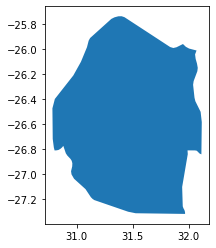

In [13]:
countries.loc[countries['ADMIN']=='eSwatini'].plot()

**Write countries to PostGIS**

In [11]:
countries.to_postgis('countries_adm', engine)

NameError: name 'countries' is not defined

# Define Variables

In [11]:
country = ['eSwatini']

## Read from PostGIS

**Import watersheds**

In [12]:
insp = inspect(engine)
insp.get_table_names()

['africa_watersheds_level8',
 'spatial_ref_sys',
 't2m_24hr',
 'd2m_24hr',
 'countries_adm',
 'test_watersheds',
 'test_thi_cat_count_gt_72',
 'eswatini_rh',
 't2m_5hr',
 'd2m',
 't2m',
 'eswatini_recov',
 'eswatini',
 'd2m_5hr',
 'eswatini_thi',
 'test_point']

In [13]:
sql = 'SELECT * FROM africa_watersheds_level8'

In [14]:
hydro_basins = gpd.read_postgis(sql, con=engine)

In [15]:
hydro_basins.head()

,id,geom,hybas_id,next_down,next_sink,main_bas,dist_sink,dist_main,sub_area,up_area,pfaf_id,endo,coast,order,sort
0,1,"MULTIPOLYGON (((32.36667 29.67917, 32.36667 29...",1080000010,0,1080000010,1080000010,0.0,0.0,1890.8,1890.8,11101100,0,1,0,1
1,2,"MULTIPOLYGON (((32.35000 29.63750, 32.35417 29...",1080000100,0,1080000100,1080000100,0.0,0.0,17.1,2925.8,11101201,0,0,1,2
2,3,"MULTIPOLYGON (((32.17500 29.49583, 32.17258 29...",1080173620,1080000100,1080000100,1080000100,10.1,10.1,170.0,2572.2,11101203,0,0,1,3
3,4,"MULTIPOLYGON (((32.36250 29.26667, 32.34758 29...",1080173880,1080000100,1080000100,1080000100,10.1,10.1,336.5,336.5,11101202,0,0,2,4
4,5,"MULTIPOLYGON (((32.10000 29.61667, 32.09583 29...",1080174070,1080173620,1080000100,1080000100,27.9,27.9,6.8,1183.9,11101205,0,0,1,5


**Crop watersheds to Country**

In [16]:
sql = 'SELECT * FROM countries_adm'

country_adm = gpd.read_postgis(sql, con=engine, geom_col='geometry')

country_adm = country_adm.loc[country_adm['ADMIN']==country[0]]

**Crop watersheds to country**

In [17]:
country_wsheds = gpd.clip(hydro_basins, country_adm) 

<AxesSubplot:>

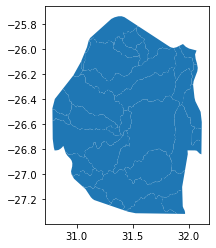

In [18]:
country_wsheds.plot()

### Soils

In [19]:
{1:'siltyclay',2:'sandyclay',3:'clayloam',4:'siltyclayloam',5:'sandyclayloam',6:'loam',7:'sandyloam',8:'loamysand',9:'sand'}

{1: 'siltyclay',
 2: 'sandyclay',
 3: 'clayloam',
 4: 'siltyclayloam',
 5: 'sandyclayloam',
 6: 'loam',
 7: 'sandyloam',
 8: 'loamysand',
 9: 'sand'}

#### Import soil classes

In [20]:
gyga_soilclass = xr.open_dataset(os.path.join(DataDir,'GIS/gyga_30cm_texclss_1km.tif'))

In [21]:
os.listdir(os.path.join(DataDir,'GIS'))

['HydroBasins',
 '.ipynb_checkpoints',
 'ne_10m_admin_0_countries.zip',
 'gyga_30cm_texclss_1km.tif',
 'Swaziland_Gridpoints.shx',
 'Swaziland_Gridpoints.shp',
 'Swaziland_Gridpoints.qmd',
 'Swaziland_Gridpoints.prj',
 'Swaziland_Gridpoints.dbf',
 'Swaziland_Gridpoints.cpg',
 'gyga_af_erzd__m_1km_rootzonedepth.tif']

**Root Zone Depth**

In [22]:
gyga_rootzonedepth = xr.open_dataset(os.path.join(DataDir,'GIS/gyga_af_erzd__m_1km_rootzonedepth.tif'))

**Soils**

In [ ]:
gyga_claycont_0_5 = xr.open_dataset(os.path.join(DataDir,'GIS/gyga_af_erzd__m_1km_rootzonedepth.tif'))

gyga_claycont_5_15 = xr.open_dataset(os.path.join(DataDir,'GIS/gyga_af_erzd__m_1km_rootzonedepth.tif'))





#### Crop soil classes

In [23]:
country_wsheds.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [24]:
country_wsheds.total_bounds

array([ 30.78290613, -27.31626434,  32.11739832, -25.73599904])

In [25]:
gyga_soilclass_country = gyga_soilclass.sel(x = slice(30.78,32.11), y= slice(-25.73, -27.31))

In [26]:
gyga_rootzonedepth_country = gyga_rootzonedepth.sel(x = slice(30.78,32.11), y= slice(-25.73, -27.31))

<AxesSubplot:title={'center':'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

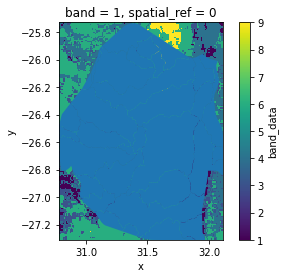

In [27]:
fig, ax = plt.subplots()

gyga_soilclass_country.band_data[0].plot(ax=ax)
country_wsheds.plot(ax=ax)

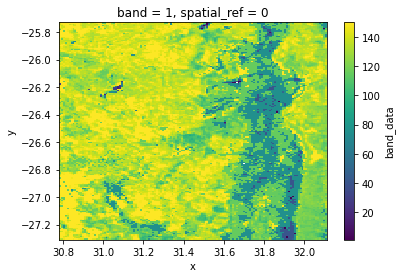

In [28]:
fig, ax = plt.subplots()

gyga_rootzonedepth_country.band_data[0].plot(ax=ax)
#country_wsheds.plot(ax=ax)

### Generate points per watershed

In [29]:
os.listdir(os.path.join(DataDir,'GIS'))

['HydroBasins',
 '.ipynb_checkpoints',
 'ne_10m_admin_0_countries.zip',
 'gyga_30cm_texclss_1km.tif',
 'Swaziland_Gridpoints.shx',
 'Swaziland_Gridpoints.shp',
 'Swaziland_Gridpoints.qmd',
 'Swaziland_Gridpoints.prj',
 'Swaziland_Gridpoints.dbf',
 'Swaziland_Gridpoints.cpg',
 'gyga_af_erzd__m_1km_rootzonedepth.tif']

**Import gridpoints**

In [30]:
gridpoints = gpd.read_file(os.path.join(DataDir,'GIS/Swaziland_Gridpoints.shp'))

**Check CRS**

In [31]:
gridpoints = gridpoints.to_crs(epsg=4326)

In [32]:
country_wsheds = country_wsheds.to_crs(epsg=4326)

In [33]:
gridpoints.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
country_wsheds.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot:>

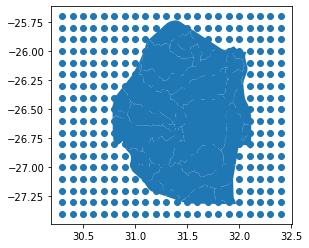

In [35]:
fig, ax = plt.subplots()

gridpoints.plot(ax=ax)

country_wsheds.plot(ax=ax)

**Test soil type extraction**

In [36]:
Sites = [('Big_Bend','-26.8','31.9','170')]

Soils = {1:'SiltClay',2:'SandyClay',3:'ClayLoam',4:'SiltClayLoam',5:'SandyClayLoam',6:'Loam',7:'SandyLoam',8:'LoamySand',9:'Sand'}

for site in Sites:
    sitename = site[0]
    Latitude = site[1]
    Longitude = site[2]
    Elevation = site[3]
    pnt_soil = gyga_soilclass_country.sel(x=Latitude,y=Longitude,  method="nearest")
    pnt_rootzoneD = gyga_rootzonedepth_country.sel(x=Latitude,y=Longitude,  method="nearest")
    pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
    pnt_class = int(pnt_soil.band_data.values)
    pnt_class_name = Soils.get(pnt_class)
    print('Lat: ',Latitude, 'Lon: ',Longitude,'Soil Class: ',pnt_class_name, 'RootZone Depth:', pnt_rootzoneD)

Lat:  -26.8 Lon:  31.9 Soil Class:  SiltClayLoam RootZone Depth: 1.43


Low_Input
yes
Running watershed number: 1081599280 Lat:  -26.00 Lon:  31.60 Elevation: 331.0 Soil Class:  Sand RootZone Depth: 1.37
Running watershed number: 1081599280 Lat:  -26.10 Lon:  31.60 Elevation: 404.0 Soil Class:  Loam RootZone Depth: 1.17
Running watershed number: 1081600970 Lat:  -26.00 Lon:  32.00 Elevation: 459.0 Soil Class:  SiltClayLoam RootZone Depth: 1.28


KeyboardInterrupt: 

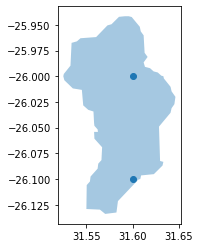

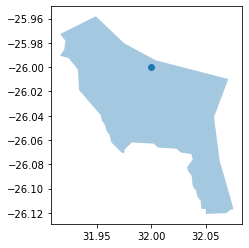

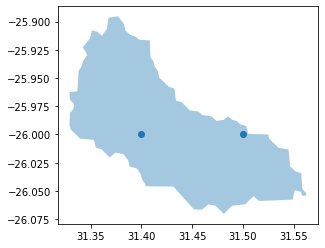

In [120]:
Soils = {1:'SiltClay',2:'SandyClay',3:'ClayLoam',4:'SiltClayLoam',5:'SandyClayLoam',6:'Loam',7:'SandyLoam',8:'LoamySand',9:'Sand'}

Swaziland_Output = pd.DataFrame()

Scenario = [{'Name':'Low_Input','IrrMethod':'0'},
            {'Name':'High_Input','IrrMethod':'4','SMT':'70'}]

for scenario in Scenario:
    print(scenario.get('Name'))
    if scenario.get('SMT') is None:
        print('yes')
    for wshed in country_wsheds.hybas_id.unique():
        fig, ax = plt.subplots()
        n_wshed = country_wsheds.loc[country_wsheds.hybas_id == wshed]
        n_wshed.plot(ax = ax, alpha=0.4)
        clipped = gpd.sjoin(gridpoints, n_wshed, predicate='within')
        if len(clipped) >0:
            clipped.plot(ax = ax)
            for idx, row in clipped.iterrows():
                lon = "{:.2f}".format(float(row.geometry.x))
                lat = "{:.2f}".format(float(row.geometry.y))
                #Soil Class
                pnt_soil = gyga_soilclass_country.sel(x=lon,y=lat,  method="nearest")
                pnt_class = int(pnt_soil.band_data.values)
                pnt_class_name = Soils.get(pnt_class)
                # Root Zone Depth
                pnt_rootzoneD = gyga_rootzonedepth_country.sel(x=lon,y=lat,  method="nearest")
                pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
                # Elevation
                Elevation = altitudo(lat=[lat], lon=[lon])
                Elevation = Elevation[0].get('elevation')
                print('Running watershed number:',wshed, 'Lat: ',lat, 'Lon: ',lon,'Elevation:',
                      Elevation,'Soil Class: ',pnt_class_name, 'RootZone Depth:', pnt_rootzoneD)

## Run Aquacrop

In [129]:
from altitudo import altitudo

In [130]:
x = altitudo(lat=[-26.00], lon=[31.60])

In [131]:
x[0].get('elevation')

331.0

In [40]:
country_wsheds.hybas_id.unique()[0:10]

array([1081599280, 1081600970, 1081600610, 1081600320, 1081599210,
       1081596150, 1081596080, 1081606440, 1081604940, 1081604890])

### Low-Input

In [100]:
Soils = {1:'SiltClay',2:'SandyClay',3:'ClayLoam',4:'SiltClayLoam',5:'SandyClayLoam',6:'Loam',7:'SandyLoam',8:'LoamySand',9:'Sand'}



Scenario = [{'Name':'Low_Input','IrrNum':'0'}]
          #  {'Name':'High_Input','IrrNum':'4','SMT':'70'}]

Combined = xr.Dataset()

for scenario in Scenario:
    Swaziland_Output = pd.DataFrame()
    print(scenario.get('Name'))
    for wshed in country_wsheds.hybas_id.unique():
        #fig, ax = plt.subplots()
        n_wshed = country_wsheds.loc[country_wsheds.hybas_id == wshed]
        #n_wshed.plot(ax = ax, alpha=0.4)
        clipped = gpd.sjoin(gridpoints, n_wshed, predicate='within')
        if len(clipped) >0:
            #clipped.plot(ax = ax)
            for idx, row in clipped.iterrows():
                lon = "{:.2f}".format(float(row.geometry.x))
                lat = "{:.2f}".format(float(row.geometry.y))
                #Soil Class
                pnt_soil = gyga_soilclass_country.sel(x=lon,y=lat,  method="nearest")
                pnt_class = int(pnt_soil.band_data.values)
                pnt_class_name = Soils.get(pnt_class)
                # Root Zone Depth
                pnt_rootzoneD = gyga_rootzonedepth_country.sel(x=lon,y=lat,  method="nearest")
                pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
                # Elevation
                Elevation = altitudo(lat=[lat], lon=[lon])
                Elevation = Elevation[0].get('elevation')
                print('Running watershed number:',wshed, 'Lat: ',lat, 'Lon: ',lon,'Elevation:',
                      Elevation,'Soil Class: ',pnt_class_name, 'RootZone Depth:', pnt_rootzoneD)
                SiteFile = pd.DataFrame()
    
    # Prepare the Calimate data for the point within the watershed    
    
                Kelvin2Celsius = lambda x: x - 273.16
                
                variables = [
                    ("2m_temperature","24_hour_minimum"),
                    ("2m_temperature","24_hour_maximum"),
                    ("precipitation_flux","daily"),
                    ("solar_radiation_flux", "daily"),
                    ("vapour_pressure", "24_hour_mean"),
                    ("10m_wind_speed", "24_hour_mean")]
                    
                print('Getting data for:',lat,' ', lon)
                for variable in variables:
                    files = glob.glob(os.path.join(DataDir,'Climate','3_combined','*{}_{}*'.format(variable[0],variable[1])))
                    df = xr.open_mfdataset(files, parallel=True, engine="netcdf4")
                    pnt = df.sel(lat=lat,lon=lon,  method="nearest")
                    df = pnt.to_dataframe()
                    df = df.drop(columns={'lat','lon'})
                    df.reset_index(inplace=True)
                    df['time'] = pd.to_datetime(df['time'])
                    df.set_index('time', inplace=True)
                    
                    if len(SiteFile) == 0:
                        SiteFile = df
                    else:
                        SiteFile = pd.concat([df,SiteFile],axis=1)
                
                SiteFile = SiteFile.rename(columns={'Wind_Speed_10m_Mean':'WIND2', 'Vapour_Pressure_Mean':'VAP','Solar_Radiation_Flux':'AVRAD',
                   'Precipitation_Flux':'Precipitation', 'Temperature_Air_2m_Max_24h':'MaxTemp',
                   'Temperature_Air_2m_Min_24h':'MinTemp'})
                
                SiteFile['LAT'] = float(lat)
                SiteFile['ELEV'] = float(Elevation)
                SiteFile.index.names = ['Date']
                SiteFile[['MinTemp','MaxTemp']] = Kelvin2Celsius(SiteFile[['MinTemp','MaxTemp']])
                
                SiteFile.reset_index(inplace=True)
                
                print('Calculating Evapotranspiration')
                for idx, row in SiteFile.iterrows():
                    SiteFile.loc[idx,'ReferenceET'] = penman_monteith(DAY=row['Date'], LAT=row['LAT'], 
                                ELEV=row['ELEV'],TMIN=row['MinTemp'],
                                TMAX=row['MaxTemp'],AVRAD=row['AVRAD'],
                                VAP=row['VAP'],WIND2=row['WIND2'])
                
                SiteFile = SiteFile[["MinTemp","MaxTemp","Precipitation","ReferenceET","Date"]]
                
                point_soil = Soil(soil_type=pnt_class_name)
                
                # Crop
                maize = Crop('Maize', planting_date='10/01', Zmax=pnt_rootzoneD)
    
                # Initial water
                InitWC = InitialWaterContent(value=['FC'])
    
                # Irrigation
                irr_num = scenario.get('IrrNum')
                soilmt = scenario.get('SMT')
                
                if soilmt is None:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num))
                else:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num),SMT=str(soilmt))
            
                # Run the model
                model = AquaCropModel(sim_start_time=f'{1979}/01/01',
                          sim_end_time=f'{2022}/01/01',
                          weather_df=SiteFile,
                          soil=point_soil,
                          crop=maize,
                          initial_water_content=InitWC,
                            irrigation_management=net_irrigation)
    
                # run model till termination
                model.run_model(till_termination=True)
                # get output
                out = model._outputs.final_stats
                out['Lat'] = lat
                out['Lon'] = lon
                out['Watershed_No'] = wshed
                out.set_index('Harvest Date (YYYY/MM/DD)', inplace=True)
                
                if len(Swaziland_Output) == 0:
                    Swaziland_Output = out
                else:
                    Swaziland_Output = pd.concat([Swaziland_Output, out])
    
    Swaziland_Output.reset_index(inplace=True)
    
    Swaziland_Output.Lat = Swaziland_Output.Lat.astype(float)

    Swaziland_Output.Lon = Swaziland_Output.Lon.astype(float)
    
    #Swaziland_Output = Swaziland_Output[[['Harvest Date (YYYY/MM/DD)','Lat','Lon','Watershed_No','Yield (tonne/ha)']]]

    Swaziland_Output.set_index(['Harvest Date (YYYY/MM/DD)','Lat','Lon','Watershed_No'], inplace=True)
    
    ds = Swaziland_Output.to_xarray()
    scene = str(scenario.get('Name'))
    ds = ds.assign_coords(Scenarios=scene)
    ds = ds.rename({'Harvest Date (YYYY/MM/DD)':'Year','Yield (tonne/ha)':'Yield (t/ha)'})
    
   # if len(Combined) == 0:
   #     Combined = ds
   # else:
   #     Combined = xr.merge([ds, Combined], compat='override')

Low_Input
Running watershed number: 1081599280 Lat:  -26.00 Lon:  31.60 Elevation: 331.0 Soil Class:  Sand RootZone Depth: 1.37
Getting data for: -26.00   31.60
Calculating Evapotranspiration
Running watershed number: 1081599280 Lat:  -26.10 Lon:  31.60 Elevation: 404.0 Soil Class:  Loam RootZone Depth: 1.17
Getting data for: -26.10   31.60
Calculating Evapotranspiration
Running watershed number: 1081600970 Lat:  -26.00 Lon:  32.00 Elevation: 459.0 Soil Class:  SiltClayLoam RootZone Depth: 1.28
Getting data for: -26.00   32.00
Calculating Evapotranspiration
Running watershed number: 1081600610 Lat:  -26.00 Lon:  31.40 Elevation: 819.5 Soil Class:  SiltClayLoam RootZone Depth: 1.44
Getting data for: -26.00   31.40
Calculating Evapotranspiration
Running watershed number: 1081600610 Lat:  -26.00 Lon:  31.50 Elevation: 383.0 Soil Class:  Loam RootZone Depth: 1.5
Getting data for: -26.00   31.50
Calculating Evapotranspiration
Running watershed number: 1081600320 Lat:  -26.00 Lon:  31.10 Ele

In [132]:
low_input = ds['Yield (t/ha)'].mean(dim='Watershed_No')

In [133]:
low_input = low_input.groupby('Year.year').mean()

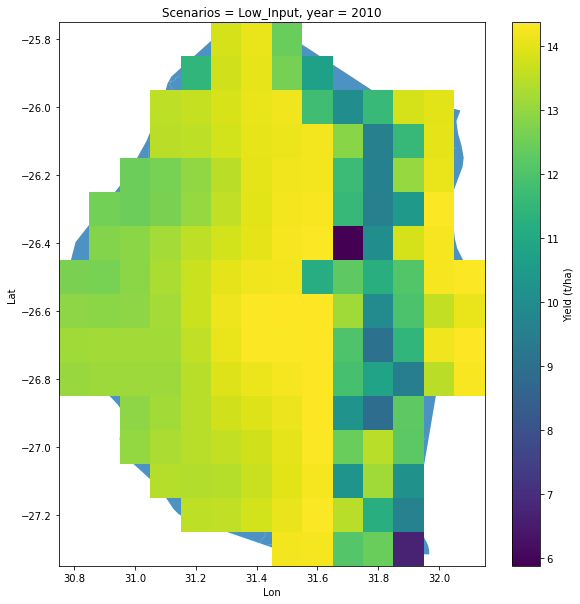

In [190]:
fig, ax = plt.subplots(figsize=(10,10))

country_wsheds.plot(ax=ax, alpha=0.8)

low_input[30,:,:].plot()

### High Input

In [136]:
Soils = {1:'SiltClay',2:'SandyClay',3:'ClayLoam',4:'SiltClayLoam',5:'SandyClayLoam',6:'Loam',7:'SandyLoam',8:'LoamySand',9:'Sand'}

Scenario = [{'Name':'High_Input','IrrNum':'4','SMT':'70'}]
          
Combined = xr.Dataset()

for scenario in Scenario:
    Swaziland_Output = pd.DataFrame()
    print(scenario.get('Name'))
    for wshed in country_wsheds.hybas_id.unique():
        #fig, ax = plt.subplots()
        n_wshed = country_wsheds.loc[country_wsheds.hybas_id == wshed]
        #n_wshed.plot(ax = ax, alpha=0.4)
        clipped = gpd.sjoin(gridpoints, n_wshed, predicate='within')
        if len(clipped) >0:
            #clipped.plot(ax = ax)
            for idx, row in clipped.iterrows():
                lon = "{:.2f}".format(float(row.geometry.x))
                lat = "{:.2f}".format(float(row.geometry.y))
                #Soil Class
                pnt_soil = gyga_soilclass_country.sel(x=lon,y=lat,  method="nearest")
                pnt_class = int(pnt_soil.band_data.values)
                pnt_class_name = Soils.get(pnt_class)
                # Root Zone Depth
                pnt_rootzoneD = gyga_rootzonedepth_country.sel(x=lon,y=lat,  method="nearest")
                pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
                # Elevation
                Elevation = altitudo(lat=[lat], lon=[lon])
                Elevation = Elevation[0].get('elevation')
                print('Running watershed number:',wshed, 'Lat: ',lat, 'Lon: ',lon,'Elevation:',
                      Elevation,'Soil Class: ',pnt_class_name, 'RootZone Depth:', pnt_rootzoneD)
                SiteFile = pd.DataFrame()
    
    # Prepare the Calimate data for the point within the watershed    
    
                Kelvin2Celsius = lambda x: x - 273.16
                
                variables = [
                    ("2m_temperature","24_hour_minimum"),
                    ("2m_temperature","24_hour_maximum"),
                    ("precipitation_flux","daily"),
                    ("solar_radiation_flux", "daily"),
                    ("vapour_pressure", "24_hour_mean"),
                    ("10m_wind_speed", "24_hour_mean")]
                    
                print('Getting data for:',lat,' ', lon)
                for variable in variables:
                    files = glob.glob(os.path.join(DataDir,'Climate','3_combined','*{}_{}*'.format(variable[0],variable[1])))
                    df = xr.open_mfdataset(files, parallel=True, engine="netcdf4")
                    pnt = df.sel(lat=lat,lon=lon,  method="nearest")
                    df = pnt.to_dataframe()
                    df = df.drop(columns={'lat','lon'})
                    df.reset_index(inplace=True)
                    df['time'] = pd.to_datetime(df['time'])
                    df.set_index('time', inplace=True)
                    
                    if len(SiteFile) == 0:
                        SiteFile = df
                    else:
                        SiteFile = pd.concat([df,SiteFile],axis=1)
                
                SiteFile = SiteFile.rename(columns={'Wind_Speed_10m_Mean':'WIND2', 'Vapour_Pressure_Mean':'VAP','Solar_Radiation_Flux':'AVRAD',
                   'Precipitation_Flux':'Precipitation', 'Temperature_Air_2m_Max_24h':'MaxTemp',
                   'Temperature_Air_2m_Min_24h':'MinTemp'})
                
                SiteFile['LAT'] = float(lat)
                SiteFile['ELEV'] = float(Elevation)
                SiteFile.index.names = ['Date']
                SiteFile[['MinTemp','MaxTemp']] = Kelvin2Celsius(SiteFile[['MinTemp','MaxTemp']])
                
                SiteFile.reset_index(inplace=True)
                
                print('Calculating Evapotranspiration')
                for idx, row in SiteFile.iterrows():
                    SiteFile.loc[idx,'ReferenceET'] = penman_monteith(DAY=row['Date'], LAT=row['LAT'], 
                                ELEV=row['ELEV'],TMIN=row['MinTemp'],
                                TMAX=row['MaxTemp'],AVRAD=row['AVRAD'],
                                VAP=row['VAP'],WIND2=row['WIND2'])
                
                SiteFile = SiteFile[["MinTemp","MaxTemp","Precipitation","ReferenceET","Date"]]
                
                point_soil = Soil(soil_type=pnt_class_name)
                
                # Crop
                maize = Crop('Maize', planting_date='10/01', Zmax=pnt_rootzoneD)
    
                # Initial water
                InitWC = InitialWaterContent(value=['FC'])
    
                # Irrigation
                irr_num = scenario.get('IrrNum')
                soilmt = scenario.get('SMT')
                
                if soilmt is None:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num))
                else:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num),SMT=str(soilmt))
            
                # Run the model
                model = AquaCropModel(sim_start_time=f'{1979}/01/01',
                          sim_end_time=f'{2022}/01/01',
                          weather_df=SiteFile,
                          soil=point_soil,
                          crop=maize,
                          initial_water_content=InitWC,
                            irrigation_management=net_irrigation)
    
                # run model till termination
                model.run_model(till_termination=True)
                # get output
                out = model._outputs.final_stats
                out['Lat'] = lat
                out['Lon'] = lon
                out['Watershed_No'] = wshed
                out.set_index('Harvest Date (YYYY/MM/DD)', inplace=True)
                
                if len(Swaziland_Output) == 0:
                    Swaziland_Output = out
                else:
                    Swaziland_Output = pd.concat([Swaziland_Output, out])
    
    Swaziland_Output.reset_index(inplace=True)
    
    Swaziland_Output.Lat = Swaziland_Output.Lat.astype(float)

    Swaziland_Output.Lon = Swaziland_Output.Lon.astype(float)
    
    #Swaziland_Output = Swaziland_Output[[['Harvest Date (YYYY/MM/DD)','Lat','Lon','Watershed_No','Yield (tonne/ha)']]]

    Swaziland_Output.set_index(['Harvest Date (YYYY/MM/DD)','Lat','Lon','Watershed_No'], inplace=True)
    
    ds = Swaziland_Output.to_xarray()
    scene = str(scenario.get('Name'))
    ds = ds.assign_coords(Scenarios=scene)
    ds = ds.rename({'Harvest Date (YYYY/MM/DD)':'Year','Yield (tonne/ha)':'Yield (t/ha)'})
    
   # if len(Combined) == 0:
   #     Combined = ds
   # else:
   #     Combined = xr.merge([ds, Combined], compat='override')

High_Input
Running watershed number: 1081599280 Lat:  -26.00 Lon:  31.60 Elevation: 331.0 Soil Class:  Sand RootZone Depth: 1.37
Getting data for: -26.00   31.60
Calculating Evapotranspiration
Running watershed number: 1081599280 Lat:  -26.10 Lon:  31.60 Elevation: 404.0 Soil Class:  Loam RootZone Depth: 1.17
Getting data for: -26.10   31.60
Calculating Evapotranspiration
Running watershed number: 1081600970 Lat:  -26.00 Lon:  32.00 Elevation: 459.0 Soil Class:  SiltClayLoam RootZone Depth: 1.28
Getting data for: -26.00   32.00
Calculating Evapotranspiration
Running watershed number: 1081600610 Lat:  -26.00 Lon:  31.40 Elevation: 819.5 Soil Class:  SiltClayLoam RootZone Depth: 1.44
Getting data for: -26.00   31.40
Calculating Evapotranspiration
Running watershed number: 1081600610 Lat:  -26.00 Lon:  31.50 Elevation: 383.0 Soil Class:  Loam RootZone Depth: 1.5
Getting data for: -26.00   31.50
Calculating Evapotranspiration
Running watershed number: 1081600320 Lat:  -26.00 Lon:  31.10 El

In [156]:
high_input = ds['Yield (t/ha)'].mean(dim='Watershed_No')

high_input = high_input.groupby('Year.year').mean()

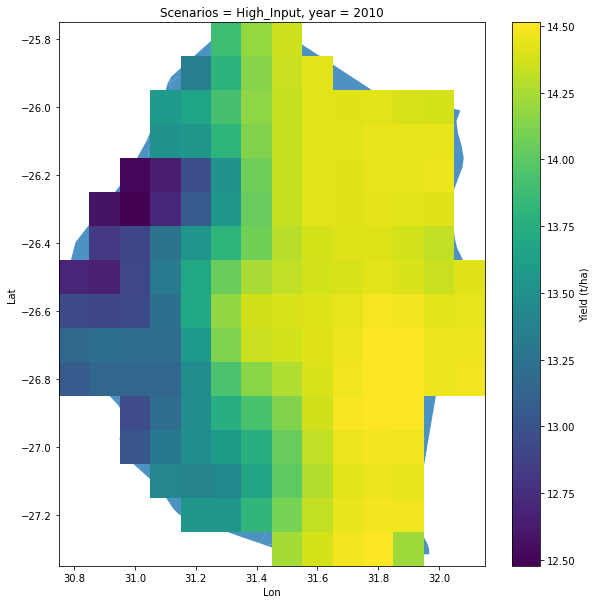

In [181]:
fig, ax = plt.subplots(figsize=(10,10))

country_wsheds.plot(ax=ax, alpha=0.8)

high_input[30,:,:].plot()

### Custom Soils

In [ ]:
gyga_claycont_0_5 = xr.open_dataset(os.path.join(DataDir,'GIS/gyga_af_erzd__m_1km_rootzonedepth.tif'))

gyga_claycont_5_15 = xr.open_dataset(os.path.join(DataDir,'GIS/gyga_af_erzd__m_1km_rootzonedepth.tif'))

In [ ]:
Soils = {1:'SiltClay',2:'SandyClay',3:'ClayLoam',4:'SiltClayLoam',5:'SandyClayLoam',6:'Loam',7:'SandyLoam',8:'LoamySand',9:'Sand'}

Scenario = [{'Name':'High_Input','IrrNum':'4','SMT':'70'}]
          
Combined = xr.Dataset()

for scenario in Scenario:
    Swaziland_Output = pd.DataFrame()
    print(scenario.get('Name'))
    for wshed in country_wsheds.hybas_id.unique():
        #fig, ax = plt.subplots()
        n_wshed = country_wsheds.loc[country_wsheds.hybas_id == wshed]
        #n_wshed.plot(ax = ax, alpha=0.4)
        clipped = gpd.sjoin(gridpoints, n_wshed, predicate='within')
        if len(clipped) >0:
            #clipped.plot(ax = ax)
            for idx, row in clipped.iterrows():
                lon = "{:.2f}".format(float(row.geometry.x))
                lat = "{:.2f}".format(float(row.geometry.y))
                #Soil Class
                pnt_soil = gyga_soilclass_country.sel(x=lon,y=lat,  method="nearest")
                pnt_class = int(pnt_soil.band_data.values)
                pnt_class_name = Soils.get(pnt_class)
                # Root Zone Depth
                pnt_rootzoneD = gyga_rootzonedepth_country.sel(x=lon,y=lat,  method="nearest")
                pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
                
                # Clay content
                
                pnt_clay_05 = 
                
                # Elevation
                Elevation = altitudo(lat=[lat], lon=[lon])
                Elevation = Elevation[0].get('elevation')
                print('Running watershed number:',wshed, 'Lat: ',lat, 'Lon: ',lon,'Elevation:',
                      Elevation,'Soil Class: ',pnt_class_name, 'RootZone Depth:', pnt_rootzoneD)
                
                
                point_soil = Soil(soil_type=pnt_class_name)
                
                point_soil.add_layer()
                
                

In [139]:
custom = Soil('custom',cn=46,rew=7)

custom.add_layer(thickness=custom.zSoil,thWP=0.24,
                 thFC=0.40,thS=0.50,Ksat=155,
                 penetrability=100)

custom = Soil('custom',cn=46,rew=7)
custom.add_layer_from_texture(thickness=custom.zSoil,
                              Sand=10,Clay=35,
                              OrgMat=2.5,penetrability=100)

custom.profile

,Comp,Layer,dz,dzsum,zBot,z_top,zMid,th_dry,th_wp,th_fc,th_s,Ksat,penetrability,tau
0,0,1.0,0.1,0.1,0.1,0.0,0.05,0.1075,0.215,0.382,0.511,136.4,100,0.48
1,1,1.0,0.1,0.2,0.2,0.1,0.15,0.1075,0.215,0.382,0.511,136.4,100,0.48
2,2,1.0,0.1,0.3,0.3,0.2,0.25,0.1075,0.215,0.382,0.511,136.4,100,0.48
3,3,1.0,0.1,0.4,0.4,0.3,0.35,0.1075,0.215,0.382,0.511,136.4,100,0.48
4,4,1.0,0.1,0.5,0.5,0.4,0.45,0.1075,0.215,0.382,0.511,136.4,100,0.48
5,5,1.0,0.1,0.6,0.6,0.5,0.55,0.1075,0.215,0.382,0.511,136.4,100,0.48
6,6,1.0,0.1,0.7,0.7,0.6,0.65,0.1075,0.215,0.382,0.511,136.4,100,0.48
7,7,1.0,0.1,0.8,0.8,0.7,0.75,0.1075,0.215,0.382,0.511,136.4,100,0.48
8,8,1.0,0.1,0.9,0.9,0.8,0.85,0.1075,0.215,0.382,0.511,136.4,100,0.48
9,9,1.0,0.1,1.0,1.0,0.9,0.95,0.1075,0.215,0.382,0.511,136.4,100,0.48


In [140]:
custom = Soil('custom',cn=46,rew=7)

custom.add_layer(thickness=0.3,thWP=0.24,
                 thFC=0.40,thS=0.50,Ksat=155,
                 penetrability=100)

custom.add_layer_from_texture(thickness=1.5,
                              Sand=10,Clay=35,
                              OrgMat=2.5,penetrability=100)

custom.profile

,Comp,Layer,dz,dzsum,zBot,z_top,zMid,th_dry,th_wp,th_fc,th_s,Ksat,penetrability,tau
0,0,1.0,0.1,0.1,0.1,0.0,0.05,0.1200,0.240,0.400,0.500,155.0,100.0,0.51
1,1,1.0,0.1,0.2,0.2,0.1,0.15,0.1200,0.240,0.400,0.500,155.0,100.0,0.51
2,2,1.0,0.1,0.3,0.3,0.2,0.25,0.1200,0.240,0.400,0.500,155.0,100.0,0.51
3,3,2.0,0.1,0.4,0.4,0.3,0.35,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
4,4,2.0,0.1,0.5,0.5,0.4,0.45,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
5,5,2.0,0.1,0.6,0.6,0.5,0.55,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
6,6,2.0,0.1,0.7,0.7,0.6,0.65,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
7,7,2.0,0.1,0.8,0.8,0.7,0.75,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
8,8,2.0,0.1,0.9,0.9,0.8,0.85,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
9,9,2.0,0.1,1.0,1.0,0.9,0.95,0.1075,0.215,0.382,0.511,136.4,100.0,0.48


In [ ]:
Soils = {1:'SiltClay',2:'SandyClay',3:'ClayLoam',4:'SiltClayLoam',5:'SandyClayLoam',6:'Loam',7:'SandyLoam',8:'LoamySand',9:'Sand'}

Scenario = [{'Name':'High_Input','IrrNum':'4','SMT':'70'}]
          
Combined = xr.Dataset()

for scenario in Scenario:
    Swaziland_Output = pd.DataFrame()
    print(scenario.get('Name'))
    for wshed in country_wsheds.hybas_id.unique():
        #fig, ax = plt.subplots()
        n_wshed = country_wsheds.loc[country_wsheds.hybas_id == wshed]
        #n_wshed.plot(ax = ax, alpha=0.4)
        clipped = gpd.sjoin(gridpoints, n_wshed, predicate='within')
        if len(clipped) >0:
            #clipped.plot(ax = ax)
            for idx, row in clipped.iterrows():
                lon = "{:.2f}".format(float(row.geometry.x))
                lat = "{:.2f}".format(float(row.geometry.y))
                #Soil Class
                pnt_soil = gyga_soilclass_country.sel(x=lon,y=lat,  method="nearest")
                pnt_class = int(pnt_soil.band_data.values)
                pnt_class_name = Soils.get(pnt_class)
                # Root Zone Depth
                pnt_rootzoneD = gyga_rootzonedepth_country.sel(x=lon,y=lat,  method="nearest")
                pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
                # Elevation
                Elevation = altitudo(lat=[lat], lon=[lon])
                Elevation = Elevation[0].get('elevation')
                print('Running watershed number:',wshed, 'Lat: ',lat, 'Lon: ',lon,'Elevation:',
                      Elevation,'Soil Class: ',pnt_class_name, 'RootZone Depth:', pnt_rootzoneD)
                SiteFile = pd.DataFrame()
    
    # Prepare the Calimate data for the point within the watershed    
    
                Kelvin2Celsius = lambda x: x - 273.16
                
                variables = [
                    ("2m_temperature","24_hour_minimum"),
                    ("2m_temperature","24_hour_maximum"),
                    ("precipitation_flux","daily"),
                    ("solar_radiation_flux", "daily"),
                    ("vapour_pressure", "24_hour_mean"),
                    ("10m_wind_speed", "24_hour_mean")]
                    
                print('Getting data for:',lat,' ', lon)
                for variable in variables:
                    files = glob.glob(os.path.join(DataDir,'Climate','3_combined','*{}_{}*'.format(variable[0],variable[1])))
                    df = xr.open_mfdataset(files, parallel=True, engine="netcdf4")
                    pnt = df.sel(lat=lat,lon=lon,  method="nearest")
                    df = pnt.to_dataframe()
                    df = df.drop(columns={'lat','lon'})
                    df.reset_index(inplace=True)
                    df['time'] = pd.to_datetime(df['time'])
                    df.set_index('time', inplace=True)
                    
                    if len(SiteFile) == 0:
                        SiteFile = df
                    else:
                        SiteFile = pd.concat([df,SiteFile],axis=1)
                
                SiteFile = SiteFile.rename(columns={'Wind_Speed_10m_Mean':'WIND2', 'Vapour_Pressure_Mean':'VAP','Solar_Radiation_Flux':'AVRAD',
                   'Precipitation_Flux':'Precipitation', 'Temperature_Air_2m_Max_24h':'MaxTemp',
                   'Temperature_Air_2m_Min_24h':'MinTemp'})
                
                SiteFile['LAT'] = float(lat)
                SiteFile['ELEV'] = float(Elevation)
                SiteFile.index.names = ['Date']
                SiteFile[['MinTemp','MaxTemp']] = Kelvin2Celsius(SiteFile[['MinTemp','MaxTemp']])
                
                SiteFile.reset_index(inplace=True)
                
                print('Calculating Evapotranspiration')
                for idx, row in SiteFile.iterrows():
                    SiteFile.loc[idx,'ReferenceET'] = penman_monteith(DAY=row['Date'], LAT=row['LAT'], 
                                ELEV=row['ELEV'],TMIN=row['MinTemp'],
                                TMAX=row['MaxTemp'],AVRAD=row['AVRAD'],
                                VAP=row['VAP'],WIND2=row['WIND2'])
                
                SiteFile = SiteFile[["MinTemp","MaxTemp","Precipitation","ReferenceET","Date"]]
                
                point_soil = Soil(soil_type=pnt_class_name)
                
                # Crop
                maize = Crop('Maize', planting_date='10/01', Zmax=pnt_rootzoneD)
    
                # Initial water
                InitWC = InitialWaterContent(value=['FC'])
    
                # Irrigation
                irr_num = scenario.get('IrrNum')
                soilmt = scenario.get('SMT')
                
                if soilmt is None:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num))
                else:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num),SMT=str(soilmt))
            
                # Run the model
                model = AquaCropModel(sim_start_time=f'{1979}/01/01',
                          sim_end_time=f'{2022}/01/01',
                          weather_df=SiteFile,
                          soil=point_soil,
                          crop=maize,
                          initial_water_content=InitWC,
                            irrigation_management=net_irrigation)
    
                # run model till termination
                model.run_model(till_termination=True)
                # get output
                out = model._outputs.final_stats
                out['Lat'] = lat
                out['Lon'] = lon
                out['Watershed_No'] = wshed
                out.set_index('Harvest Date (YYYY/MM/DD)', inplace=True)
                
                if len(Swaziland_Output) == 0:
                    Swaziland_Output = out
                else:
                    Swaziland_Output = pd.concat([Swaziland_Output, out])
    
    Swaziland_Output.reset_index(inplace=True)
    
    Swaziland_Output.Lat = Swaziland_Output.Lat.astype(float)

    Swaziland_Output.Lon = Swaziland_Output.Lon.astype(float)
    
    #Swaziland_Output = Swaziland_Output[[['Harvest Date (YYYY/MM/DD)','Lat','Lon','Watershed_No','Yield (tonne/ha)']]]

    Swaziland_Output.set_index(['Harvest Date (YYYY/MM/DD)','Lat','Lon','Watershed_No'], inplace=True)
    
    ds = Swaziland_Output.to_xarray()
    scene = str(scenario.get('Name'))
    ds = ds.assign_coords(Scenarios=scene)
    ds = ds.rename({'Harvest Date (YYYY/MM/DD)':'Year','Yield (tonne/ha)':'Yield (t/ha)'})
    
   # if len(Combined) == 0:
   #     Combined = ds
   # else:
   #     Combined = xr.merge([ds, Combined], compat='override')

## Custom Planting

In [ ]:
# function to return the irrigation depth to apply on next day
def get_depth(model):    
    t = model._clock_struct.time_step_counter # current timestep
    # get weather data for next 7 days
    weather10 = model._weather[t+1:min(t+10+1,len(model._weather))]
    # if it will rain in next 7 days
    if sum(weather10[:,2])>0:
        # check if soil is over 70% depleted
        if t>0 and model._init_cond.depletion/model._init_cond.taw > 0.7:
            depth=10
        else:
            depth=0
    else:
        # no rain for next 10 days
        depth=10


    return depth

In [57]:
Soils = {1:'SiltClay',2:'SandyClay',3:'ClayLoam',4:'SiltClayLoam',5:'SandyClayLoam',6:'Loam',7:'SandyLoam',8:'LoamySand',9:'Sand'}

Swaziland_Output = pd.DataFrame()

Scenario = [{'Name':'Low_Input','IrrNum':'0'}]
  #          {'Name':'High_Input','IrrNum':'4','SMT':'70'}]

for scenario in Scenario:
    print(scenario.get('Name'))
    for wshed in country_wsheds.hybas_id.unique()[0:1]:
        #fig, ax = plt.subplots()
        n_wshed = country_wsheds.loc[country_wsheds.hybas_id == wshed]
        #n_wshed.plot(ax = ax, alpha=0.4)
        clipped = gpd.sjoin(gridpoints, n_wshed, predicate='within')
        if len(clipped) >0:
            #clipped.plot(ax = ax)
            for idx, row in clipped.iterrows():
                lon = "{:.2f}".format(float(row.geometry.x))
                lat = "{:.2f}".format(float(row.geometry.y))
                #Soil Class
                pnt_soil = gyga_soilclass_country.sel(x=lon,y=lat,  method="nearest")
                pnt_class = int(pnt_soil.band_data.values)
                pnt_class_name = Soils.get(pnt_class)
                # Root Zone Depth
                pnt_rootzoneD = gyga_rootzonedepth_country.sel(x=lon,y=lat,  method="nearest")
                pnt_rootzoneD = int(pnt_rootzoneD.band_data.values) / 100
                # Elevation
                Elevation = altitudo(lat=[lat], lon=[lon])
                Elevation = Elevation[0].get('elevation')
                print('Running watershed number:',wshed, 'Lat: ',lat, 'Lon: ',lon,'Elevation:',
                      Elevation,'Soil Class: ',pnt_class_name, 'RootZone Depth:', pnt_rootzoneD)
                SiteFile = pd.DataFrame()
    
    # Prepare the Calimate data for the point within the watershed    
    
                Kelvin2Celsius = lambda x: x - 273.16
                
                variables = [
                    ("2m_temperature","24_hour_minimum"),
                    ("2m_temperature","24_hour_maximum"),
                    ("precipitation_flux","daily"),
                    ("solar_radiation_flux", "daily"),
                    ("vapour_pressure", "24_hour_mean"),
                    ("10m_wind_speed", "24_hour_mean")]
                    
                print('Getting data for:',lat,' ', lon)
                for variable in variables:
                    files = glob.glob(os.path.join(DataDir,'Climate','3_combined','*{}_{}*'.format(variable[0],variable[1])))
                    df = xr.open_mfdataset(files, parallel=True, engine="netcdf4")
                    pnt = df.sel(lat=lat,lon=lon,  method="nearest")
                    df = pnt.to_dataframe()
                    df = df.drop(columns={'lat','lon'})
                    df.reset_index(inplace=True)
                    df['time'] = pd.to_datetime(df['time'])
                    df.set_index('time', inplace=True)
                    
                    if len(SiteFile) == 0:
                        SiteFile = df
                    else:
                        SiteFile = pd.concat([df,SiteFile],axis=1)
                
                SiteFile = SiteFile.rename(columns={'Wind_Speed_10m_Mean':'WIND2', 'Vapour_Pressure_Mean':'VAP','Solar_Radiation_Flux':'AVRAD',
                   'Precipitation_Flux':'Precipitation', 'Temperature_Air_2m_Max_24h':'MaxTemp',
                   'Temperature_Air_2m_Min_24h':'MinTemp'})
                
                SiteFile['LAT'] = float(lat)
                SiteFile['ELEV'] = float(Elevation)
                SiteFile.index.names = ['Date']
                SiteFile[['MinTemp','MaxTemp']] = Kelvin2Celsius(SiteFile[['MinTemp','MaxTemp']])
                
                SiteFile.reset_index(inplace=True)
                
                print('Calculating Evapotranspiration')
                for idx, row in SiteFile.iterrows():
                    SiteFile.loc[idx,'ReferenceET'] = penman_monteith(DAY=row['Date'], LAT=row['LAT'], 
                                ELEV=row['ELEV'],TMIN=row['MinTemp'],
                                TMAX=row['MaxTemp'],AVRAD=row['AVRAD'],
                                VAP=row['VAP'],WIND2=row['WIND2'])
                
                SiteFile = SiteFile[["MinTemp","MaxTemp","Precipitation","ReferenceET","Date"]]
                
                point_soil = Soil(soil_type=pnt_class_name)
                
                # Crop
                maize = Crop('Maize', planting_date='10/01', Zmax=pnt_rootzoneD)
    
                # Initial water
                InitWC = InitialWaterContent(value=['FC'])
    
                # Irrigation
                irr_num = scenario.get('IrrNum')
                soilmt = scenario.get('SMT')
                
                if soilmt is None:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num))
                else:
                    net_irrigation = IrrigationManagement(irrigation_method=int(irr_num),SMT=str(soilmt))
            
                # Run the model
                model = AquaCropModel(sim_start_time=f'{1979}/01/01',
                          sim_end_time=f'{2022}/01/01',
                          weather_df=SiteFile,
                          soil=point_soil,
                          crop=maize,
                          initial_water_content=InitWC,
                            irrigation_management=net_irrigation)
    
                # run model till termination
                model.run_model(till_termination=True)
                # get output
                out = model._outputs.final_stats
                out['Lat'] = lat
                out['Lon'] = lon
                out['Watershed_No'] = wshed
                out.set_index('Harvest Date (YYYY/MM/DD)', inplace=True)
                
                if len(Swaziland_Output) == 0:
                    Swaziland_Output = out
                else:
                    Swaziland_Output = pd.concat([Swaziland_Output, out])
    
    Swaziland_Output.reset_index(inplace=True)

    Swaziland_Output.Lat = Swaziland_Output.Lat.astype(float)

    Swaziland_Output.Lon = Swaziland_Output.Lon.astype(float)
    
    Swaziland_Output = Swaziland_Output[[['Harvest Date (YYYY/MM/DD)','Lat','Lon','Watershed_No','Yield (tonne/ha)']]]

    Swaziland_Output.set_index(['Harvest Date (YYYY/MM/DD)','Lat','Lon','Watershed_No'], inplace=True)
    
    ds = Swaziland_Output.to_xarray()
    ds = ds.assign_coords({'Scenario':('scenario', scenario.get('Name'))})
    ds = ds.rename({'Harvest Date (YYYY/MM/DD)':'Year','Yield (tonne/ha)':'Yield (t/ha)'})

Low_Input
Running watershed number: 1081599280 Lat:  -26.00 Lon:  31.60 Elevation: 331.0 Soil Class:  Sand RootZone Depth: 1.37
Getting data for: -26.00   31.60
Calculating Evapotranspiration
Running watershed number: 1081599280 Lat:  -26.10 Lon:  31.60 Elevation: 404.0 Soil Class:  Loam RootZone Depth: 1.17
Getting data for: -26.10   31.60
Calculating Evapotranspiration


KeyError: "None of [Index([('Harvest Date (YYYY/MM/DD)', 'Lat', 'Lon', 'Watershed_No', 'Yield (tonne/ha)')], dtype='object')] are in the [columns]"

In [58]:
Swaziland_Output.reset_index(inplace=True)

In [59]:
Swaziland_Output.Lat = Swaziland_Output.Lat.astype(float)

In [60]:
Swaziland_Output.Lon = Swaziland_Output.Lon.astype(float)

In [61]:
Swaziland_Output.set_index(['Harvest Date (YYYY/MM/DD)','Lat','Lon','Watershed_No'], inplace=True)

In [62]:
Swaziland_Output

,,,,Season,crop Type,Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
Harvest Date (YYYY/MM/DD),Lat,Lon,Watershed_No,,,,,
1980-02-10,-26.0,31.6,1081599280,0,Maize,404,12.366047,0
1981-02-10,-26.0,31.6,1081599280,1,Maize,770,13.054122,0
1982-02-10,-26.0,31.6,1081599280,2,Maize,1135,11.121883,0
1983-02-10,-26.0,31.6,1081599280,3,Maize,1500,4.985944,0
1984-02-10,-26.0,31.6,1081599280,4,Maize,1865,9.912059,0
...,...,...,...,...,...,...,...,...
2017-02-10,-26.2,31.4,1081600680,37,Maize,13919,14.345383,0
2018-02-10,-26.2,31.4,1081600680,38,Maize,14284,14.170850,0
2019-02-10,-26.2,31.4,1081600680,39,Maize,14649,14.401903,0


In [75]:
ds = Swaziland_Output.to_xarray()

In [76]:
ds = ds.rename({'Harvest Date (YYYY/MM/DD)':'Year','Yield (tonne/ha)':'Yield (t/ha)'})

In [77]:
ds

<xarray.Dataset>
Dimensions:                   (Year: 187, Lat: 16, Lon: 14, Watershed_No: 31)
Coordinates:
  * Year                      (Year) datetime64[ns] 1980-02-01 ... 2021-12-26
  * Lat                       (Lat) float64 -27.3 -27.2 -27.1 ... -25.9 -25.8
  * Lon                       (Lon) float64 30.8 30.9 31.0 ... 31.9 32.0 32.1
  * Watershed_No              (Watershed_No) int64 1080012770 ... 1081613850
Data variables:
    Season                    (Year, Lat, Lon, Watershed_No) float64 nan ... nan
    crop Type                 (Year, Lat, Lon, Watershed_No) object nan ... nan
    Harvest Date (Step)       (Year, Lat, Lon, Watershed_No) float64 nan ... nan
    Yield (t/ha)              (Year, Lat, Lon, Watershed_No) float64 nan ... nan
    Seasonal irrigation (mm)  (Year, Lat, Lon, Watershed_No) float64 nan ... nan

In [79]:
ds = ds['Yield (t/ha)'].mean(dim='Watershed_No')

In [82]:
ds.Year

<xarray.DataArray 'Year' (Year: 187)>
array(['1980-02-01T00:00:00.000000000', '1980-02-02T00:00:00.000000000',
       '1980-02-03T00:00:00.000000000', '1980-02-04T00:00:00.000000000',
       '1980-02-10T00:00:00.000000000', '1981-02-10T00:00:00.000000000',
       '1982-01-21T00:00:00.000000000', '1982-02-10T00:00:00.000000000',
       '1982-11-28T00:00:00.000000000', '1982-12-07T00:00:00.000000000',
       '1982-12-12T00:00:00.000000000', '1982-12-13T00:00:00.000000000',
       '1982-12-14T00:00:00.000000000', '1982-12-15T00:00:00.000000000',
       '1982-12-17T00:00:00.000000000', '1982-12-20T00:00:00.000000000',
       '1982-12-21T00:00:00.000000000', '1982-12-23T00:00:00.000000000',
       '1982-12-24T00:00:00.000000000', '1982-12-25T00:00:00.000000000',
       '1983-01-25T00:00:00.000000000', '1983-01-30T00:00:00.000000000',
       '1983-01-31T00:00:00.000000000', '1983-02-01T00:00:00.000000000',
       '1983-02-10T00:00:00.000000000', '1984-01-28T00:00:00.000000000',
       '1984-02-10T00:00:00.000000000', '1985-02-10T00:00:00.000000000',
       '1986-01-04T00:00:00.000000000', '1986-02-10T00:00:00.000000000',
       '1986-12-12T00:00:00.000000000', '1986-12-18T00:00:00.000000000',
       '1986-12-19T00:00:00.000000000', '1986-12-20T00:00:00.000000000',
       '1986-12-24T00:00:00.000000000', '1986-12-26T00:00:00.000000000',
       '1987-02-10T00:00:00.000000000', '1988-01-20T00:00:00.000000000',
       '1988-02-10T00:00:00.000000000', '1988-11-27T00:00:00.000000000',
       '1988-12-01T00:00:00.000000000', '1989-01-29T00:00:00.000000000',
       '1989-02-01T00:00:00.000000000', '1989-02-02T00:00:00.000000000',
       '1989-02-08T00:00:00.000000000', '1989-02-10T00:00:00.000000000',
       '1990-02-10T00:00:00.000000000', '1990-12-02T00:00:00.000000000',
       '1991-02-10T00:00:00.000000000', '1992-01-20T00:00:00.000000000',
       '1992-01-22T00:00:00.000000000', '1992-01-23T00:00:00.000000000',
       '1992-01-24T00:00:00.000000000', '1992-01-25T00:00:00.000000000',
       '1992-01-26T00:00:00.000000000', '1992-01-27T00:00:00.000000000',
       '1992-01-28T00:00:00.000000000', '1992-01-29T00:00:00.000000000',
       '1992-02-10T00:00:00.000000000', '1993-01-30T00:00:00.000000000',
       '1993-02-01T00:00:00.000000000', '1993-02-03T00:00:00.000000000',
       '1993-02-04T00:00:00.000000000', '1993-02-08T00:00:00.000000000',
       '1993-02-10T00:00:00.000000000', '1993-12-02T00:00:00.000000000',
       '1993-12-11T00:00:00.000000000', '1993-12-19T00:00:00.000000000',
       '1993-12-20T00:00:00.000000000', '1993-12-21T00:00:00.000000000',
       '1993-12-22T00:00:00.000000000', '1993-12-23T00:00:00.000000000',
       '1993-12-24T00:00:00.000000000', '1993-12-25T00:00:00.000000000',
       '1993-12-26T00:00:00.000000000', '1993-12-27T00:00:00.000000000',
       '1993-12-28T00:00:00.000000000', '1993-12-29T00:00:00.000000000',
       '1993-12-30T00:00:00.000000000', '1994-02-10T00:00:00.000000000',
       '1995-01-11T00:00:00.000000000', '1995-01-13T00:00:00.000000000',
       '1995-01-15T00:00:00.000000000', '1995-02-10T00:00:00.000000000',
       '1996-02-10T00:00:00.000000000', '1996-12-17T00:00:00.000000000',
       '1996-12-18T00:00:00.000000000', '1996-12-20T00:00:00.000000000',
       '1996-12-22T00:00:00.000000000', '1996-12-24T00:00:00.000000000',
       '1996-12-26T00:00:00.000000000', '1997-01-03T00:00:00.000000000',
       '1997-02-10T00:00:00.000000000', '1998-02-10T00:00:00.000000000',
       '1999-02-10T00:00:00.000000000', '2000-02-10T00:00:00.000000000',
       '2001-02-10T00:00:00.000000000', '2002-01-25T00:00:00.000000000',
       '2002-01-26T00:00:00.000000000', '2002-02-10T00:00:00.000000000',
       '2002-12-05T00:00:00.000000000', '2002-12-13T00:00:00.000000000',
       '2002-12-19T00:00:00.000000000', '2003-01-02T00:00:00.000000000',
       '2003-01-03T00:00:00.000000000', '2003-01-06T00:00:00.000000000',
       '2003-01-08T00:00:00.000000000', '2003-01-09T00:00:00.000000000',
       '2003-02-10T0

In [84]:
ds = ds.groupby('Year.year').mean()

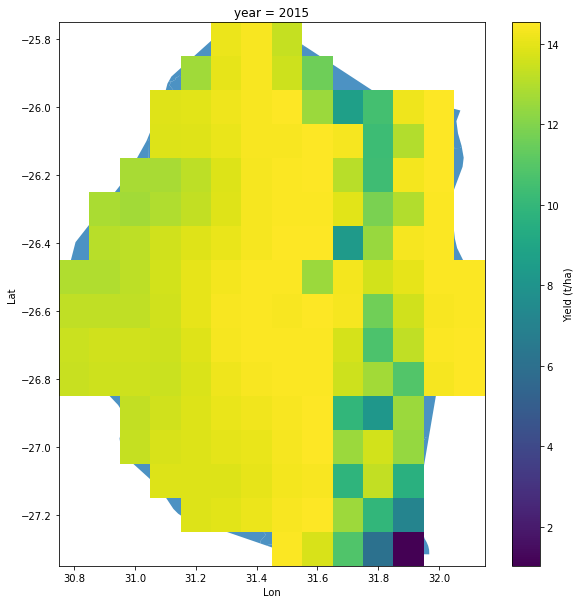

In [105]:
fig, ax = plt.subplots(figsize=(10,10))

country_wsheds.plot(ax=ax, alpha=0.8)

ds[35,:,:].plot()

#### Swaziland_Output.groupby('Watershed_No')['Yield (tonne/ha)'

### Get data from WebCoverageService : ISRIC

In [ ]:
wcs = WebCoverageService('https://maps.isric.org/mapserv?map=/map/gyga.map')

In [79]:
print([op.name for op in wcs.operations])

['GetCapabilities', 'DescribeCoverage', 'GetCoverage']


In [80]:
print(list(wcs.contents))

['gyga_af_agg_30cm_awcpf23__m_1km', 'gyga_af_agg_30cm_crfvol__m_1km', 'gyga_af_agg_30cm_pwp__m_1km', 'gyga_af_agg_30cm_tawcpf23mm__m_1km', 'gyga_af_agg_30cm_tetas__m_1km', 'gyga_af_agg_30cm_texclss__m_1km', 'gyga_af_agg_erzd_awcpf23__m_1km', 'gyga_af_agg_erzd_crfvol__m_1km', 'gyga_af_agg_erzd_pwp__m_1km', 'gyga_af_agg_erzd_tawcpf23mm__m_1km', 'gyga_af_agg_erzd_tetas__m_1km', 'gyga_af_agg_erzd_texclss__m_1km', 'gyga_af_erzd__m_1km', 'gyga_af_erzd_limfactor__m_1km']


In [223]:
wrb_soilclass= wcs.contents['gyga_af_agg_erzd_texclss__m_1km']
wrb_soilclass.supportedFormats

['image/tiff',
 'image/png',
 'image/jpeg',
 'image/png; mode=8bit',
 'image/vnd.jpeg-png',
 'image/vnd.jpeg-png8']

In [231]:
wrb_soilclass.boundingboxes

[{'nativeSrs': 'http://www.opengis.net/def/crs/EPSG/0/152161',
  'bbox': (-3976000.0, -4321000.0, 3398000.0, 3554000.0)}]

In [232]:
crs = "http://www.opengis.net/def/crs/EPSG/0/4326"

Each tuple is a triplet: (axis identifier, minimum, maximum).

In [233]:
country_adm.total_bounds

array([ 30.78290613, -27.31626434,  32.11739832, -25.73599904])

In [245]:
country_transf = country_adm.to_crs('ESRI:102020')

country_adm.bounds

subset = [('X', float(country_transf.bounds.minx.values),float(country_transf.bounds.maxx.values)),
          ('Y', float(country_transf.bounds.miny.values),float(country_transf.bounds.maxy.values))]

In [246]:
subset

[('X', 3423538.6304844744, 3589759.1021538465),
 ('Y', 5630948.426505909, 5796543.338091943)]

In [247]:
country_transf.total_bounds

array([3423538.63048447, 5630948.42650591, 3589759.10215385,
       5796543.33809194])

In [249]:
country_soil = wcs.getCoverage(identifier=['gyga_af_agg_erzd_texclss__m_1km'],subsets=subset,
                                    format=wrb_soilclass.supportedFormats[0])

ServiceException: <?xml version="1.0" encoding="UTF-8"?>
<ows:ExceptionReport xmlns:ows="http://www.opengis.net/ows/2.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" version="2.0.1" xml:lang="en-US" xsi:schemaLocation="http://www.opengis.net/ows/2.0 http://schemas.opengis.net/ows/2.0/owsExceptionReport.xsd">
  <ows:Exception exceptionCode="ExtentError" locator="extent">
    <ows:ExceptionText>msWCSGetCoverage20(): WCS server error. Image extent does not intersect with desired region.</ows:ExceptionText>
  </ows:Exception>
</ows:ExceptionReport>


In [250]:
from owslib.wcs import WebCoverageService

wcs = WebCoverageService('https://maps.isric.org/mapserv?map=/map/gyga.map',
                         version='2.0.1')

cov_id = 'gyga_af_agg_erzd_texclss__m_1km'
ph_0_5 = wcs.contents[cov_id]
ph_0_5.supportedFormats

subsets = [('X', 3423538, 3589759),
 ('Y', 5630948, 5796543)]

[('X', 591942, 728506),
 ('Y', -3146446, -2975803)]

crs = "http://www.opengis.net/def/crs/EPSG/0/4326"

response = wcs.getCoverage(
    identifier=[cov_id], 
    crs=crs,
    subsets=subsets,
    format=ph_0_5.supportedFormats[0])

ServiceException: <?xml version="1.0" encoding="UTF-8"?>
<ows:ExceptionReport xmlns:ows="http://www.opengis.net/ows/2.0" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" version="2.0.1" xml:lang="en-US" xsi:schemaLocation="http://www.opengis.net/ows/2.0 http://schemas.opengis.net/ows/2.0/owsExceptionReport.xsd">
  <ows:Exception exceptionCode="ExtentError" locator="extent">
    <ows:ExceptionText>msWCSGetCoverage20(): WCS server error. Image extent does not intersect with desired region.</ows:ExceptionText>
  </ows:Exception>
</ows:ExceptionReport>


In [243]:
with open('Senegal_pH_0-5_mean.tif', 'wb') as file:
    file.write(response.read())

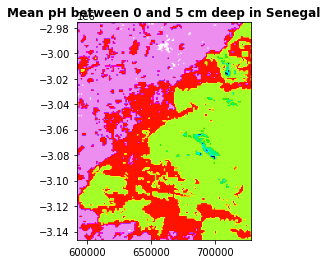

<AxesSubplot:title={'center':'Mean pH between 0 and 5 cm deep in Senegal'}>

In [244]:
import rasterio
from rasterio import plot

ph = rasterio.open("Senegal_pH_0-5_mean.tif", driver="GTiff")
%matplotlib inline
plot.show(ph, title='Mean pH between 0 and 5 cm deep in Senegal', cmap='gist_ncar')

# Weather

In [235]:
weather = pd.read_csv(DataDir/'Climate/04_sitefiles/AgERA5_Big_Bend.csv', index_col=0, parse_dates=['Date'])

In [236]:
weather_data = weather

## Define the sites and parameters we need to model

Here we automate the modelling process. The input parameters for a given site is specified and modelled.

In [237]:
Sites = [{'Name':'Big_Bend','Soil':'SandyLoam','Crop':'SugerCane'}]

for site in Sites:
    name = site.get('Name')
    print(name)

Big_Bend


In [238]:
# Soil

sandy_loam = Soil(soil_type='SandyLoam')
clay_loam = Soil(soil_type='ClayLoam')

# Crop

maize = Crop('Maize', planting_date='10/01')
sugercane = Crop('SugarCane', planting_date='11/1', harvest_date='04/10',CGC=0.420,
                 CDC=0.226,
                 PlantPop=100000)


# Initial water
InitWC = InitialWaterContent(value=['FC'])

# Irrigation

#net_irrigation = IrrigationManagement(irrigation_method=4,NetIrrSMT=70)

net_irrigation = IrrigationManagement(irrigation_method=0)


In [239]:
# combine into aquacrop model and specify start and end simulation date
model = AquaCropModel(sim_start_time=f'{1979}/01/01',
                      sim_end_time=f'{2022}/01/01',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=maize,
                      initial_water_content=InitWC)

# run model till termination
model.run_model(till_termination=True)

# model._outputs.water_flux.head()
# model._outputs.water_storage.head()
#model._outputs.crop_growth.head()
model._outputs.final_stats.head()

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Maize,1980-02-10,404,11.412894,0
1,1,Maize,1981-02-10,770,12.533013,0
2,2,Maize,1982-02-10,1135,11.115747,0
3,3,Maize,1983-02-10,1500,8.331252,0
4,4,Maize,1984-02-10,1865,12.664608,0


In [240]:
out = model._outputs.final_stats

In [241]:
out

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Maize,1980-02-10,404,11.412894,0
1,1,Maize,1981-02-10,770,12.533013,0
2,2,Maize,1982-02-10,1135,11.115747,0
3,3,Maize,1983-02-10,1500,8.331252,0
4,4,Maize,1984-02-10,1865,12.664608,0
5,5,Maize,1985-02-10,2231,13.592043,0
6,6,Maize,1986-02-10,2596,13.751872,0
7,7,Maize,1987-02-10,2961,10.885517,0
8,8,Maize,1988-02-10,3326,12.623180,0
9,9,Maize,1989-02-10,3692,12.204667,0


## Weather station data

#### Big Bend

In [297]:
weather_bb = pd.read_excel(DataDir/'Weather/WW_Custom_CSW_554_20220920.xlsx', parse_dates=[1])
weather_bb.rename(columns={'Weather_Date':'Date','Min_Temp':'MinTemp','Max_Temp':'MaxTemp','Rainfall':'Precipitation','Daily_Evaporation':'ReferenceET'}, inplace=True)
weather_bb.drop(columns={'Station_ID','Wind', 'Temp_D8', 'Temp_W14', 'Temp_D14', 'Rel_Humidity_8',
       'Rel_Humidity_14', 'Min_Rel_Humidity', 'Max_Rel_Humidity',
       'Mean_Vapour', 'Apan_Evaporation',
       'Sunshine_Hours', 'Growth', 'Missing_Data_Code', 'SWC60', 'SWC100',
       'SWC140'}, inplace=True)
weather_bb = weather_bb[['MinTemp','MaxTemp','Precipitation', 'ReferenceET','Date']]

weather_data_bb = weather_bb.dropna(how='any')

In [346]:
weather_bb

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,18.06,29.08,0.0,4.40,1979-10-31
1,17.50,30.50,0.0,3.55,1979-11-01
2,16.50,31.00,0.0,5.44,1979-11-02
3,20.50,29.80,5.0,4.82,1979-11-03
4,20.30,37.30,0.0,6.86,1979-11-04
...,...,...,...,...,...
13538,18.80,39.50,0.0,7.83,2017-02-02
13539,24.60,35.50,0.0,8.09,2017-02-03
13540,20.00,36.00,0.0,7.88,2017-02-04
13541,21.50,38.80,0.0,8.28,2017-02-05


#### Mhlume RSSC 26'10'0, 31'48'0

In [298]:
weather_mh = pd.read_excel(DataDir/'Weather/WW_Custom_CSW_555_20220920.xlsx', parse_dates=[1])
weather_mh.rename(columns={'Weather_Date':'Date','Min_Temp':'MinTemp','Max_Temp':'MaxTemp','Rainfall':'Precipitation','Daily_Evaporation':'ReferenceET'}, inplace=True)
weather_mh.drop(columns={'Station_ID','Wind', 'Temp_D8', 'Temp_W14', 'Temp_D14', 'Rel_Humidity_8',
       'Rel_Humidity_14', 'Min_Rel_Humidity', 'Max_Rel_Humidity',
       'Mean_Vapour', 'Apan_Evaporation',
       'Sunshine_Hours', 'Growth', 'Missing_Data_Code', 'SWC60', 'SWC100',
       'SWC140'}, inplace=True)
weather_mh = weather_mh[['MinTemp','MaxTemp','Precipitation', 'ReferenceET','Date']]
weather_mh = weather_mh.dropna(how='any')

In [345]:
weather_mh

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,14.59,26.55,0.0,3.47,1968-04-30
1,15.80,30.50,0.0,4.42,1968-05-01
2,9.20,30.20,0.0,3.37,1968-05-02
3,12.70,32.10,0.0,3.80,1968-05-03
4,10.00,30.40,0.0,3.62,1968-05-04
...,...,...,...,...,...
17007,18.49,30.67,0.0,4.25,2014-11-22
17008,18.24,31.15,4.5,4.56,2014-11-23
17009,18.23,30.85,0.3,6.13,2014-11-24
17010,17.06,27.39,1.6,4.85,2014-11-25


#### Simunye Mlaula 26'12'0, 31'54'0

In [299]:
weather_sm = pd.read_excel(DataDir/'Weather/WW_Custom_CSW_553_20220920.xlsx', parse_dates=[1])
weather_sm.rename(columns={'Weather_Date':'Date','Min_Temp':'MinTemp','Max_Temp':'MaxTemp','Rainfall':'Precipitation','Daily_Evaporation':'ReferenceET'}, inplace=True)
weather_sm.drop(columns={'Station_ID','Wind', 'Temp_D8', 'Temp_W14', 'Temp_D14', 'Rel_Humidity_8',
       'Rel_Humidity_14', 'Min_Rel_Humidity', 'Max_Rel_Humidity',
       'Mean_Vapour', 'Apan_Evaporation',
       'Sunshine_Hours', 'Growth', 'Missing_Data_Code', 'SWC60', 'SWC100',
       'SWC140'}, inplace=True)
weather_sm = weather_sm[['MinTemp','MaxTemp','Precipitation', 'ReferenceET','Date']]

weather_sm = weather_sm.dropna(how='any')

In [344]:
weather_sm

,MinTemp,MaxTemp,Precipitation,ReferenceET,Date
0,14.29,26.74,0.0,3.14,1979-04-30
1,14.11,32.60,0.0,3.96,1979-05-01
2,19.00,32.90,0.0,5.14,1979-05-02
3,18.20,33.50,0.0,6.14,1979-05-03
4,19.90,28.40,0.0,5.18,1979-05-04
...,...,...,...,...,...
13715,17.75,36.06,0.0,6.79,2017-02-02
13716,21.40,33.28,0.0,7.38,2017-02-03
13717,19.39,34.02,0.0,7.44,2017-02-04
13718,20.27,36.66,0.0,7.74,2017-02-05


# Soil

In [359]:
sandy_loam = Soil(soil_type='SandyLoam')
clay_loam = Soil(soil_type='ClayLoam')

# Crop

In [441]:
maize = Crop('Maize', planting_date='10/01')
sugercane = Crop('SugarCane', planting_date='10/1', harvest_date='04/15',PlantMethod=1 )

# Initial water

In [445]:
InitWC = InitialWaterContent(value=['SAT'])

# Irrigation

In [399]:
net_irrigation = IrrigationManagement(irrigation_method=4,NetIrrSMT=70)

# Model

In [417]:
# combine into aquacrop model and specify start and end simulation date
model = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/10/01',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=sugercane,
                      initial_water_content=InitWC)

In [418]:
# run model till termination
model.run_model(till_termination=True)

True

In [419]:
# model._outputs.water_flux.head()
# model._outputs.water_storage.head()
#model._outputs.crop_growth.head()
model._outputs.final_stats.head()

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,SugarCane,2000-10-01,243,13.075364,0
1,1,SugarCane,2001-08-08,554,8.541564,0
2,2,SugarCane,2002-09-22,964,8.984006,0
3,3,SugarCane,2003-08-19,1295,8.211898,0
4,4,SugarCane,2004-10-01,1704,12.969710,0


## Model different soil

In [403]:
# combine into aquacrop model and specify start and end simulation date
model_clay = AquaCropModel(sim_start_time=f'{2000}/10/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_data,
                      soil=Soil('Clay'),
                      crop=wheat,
                      initial_water_content=InitWC)

model_clay.run_model(till_termination=True)

True

In [404]:
names=['Sandy Loam','Clay']

#combine our two output files
dflist=[model._outputs.final_stats,
        model_clay._outputs.final_stats] 

outlist=[]
for i in range(len(dflist)): # go through our two output files
    temp = pd.DataFrame(dflist[i]['Yield (tonne/ha)']) # extract the seasonal yield data
    temp['label']=names[i] # add the soil type label
    outlist.append(temp) # save processed results

# combine results
all_outputs = pd.concat(outlist,axis=0)

Text(0, 0.5, 'Yield (tonne/ha)')

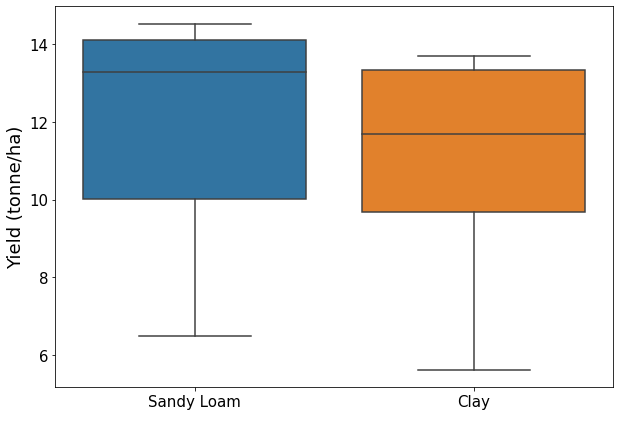

In [405]:
#create figure
fig,ax=plt.subplots(1,1,figsize=(10,7),)

# create box plot
sns.boxplot(data=all_outputs,x='label',y='Yield (tonne/ha)',ax=ax,)

# labels and font sizes
ax.tick_params(labelsize=15)
ax.set_xlabel(' ')
ax.set_ylabel('Yield (tonne/ha)',fontsize=18)

# Model different locations

In [517]:
InitWC = InitialWaterContent(value=['FC'])

In [713]:
net_irrigation = IrrigationManagement(irrigation_method=4,NetIrrSMT=70)

In [811]:
sugercane = Crop('SugarCane', planting_date='11/1', harvest_date='04/10',CGC=0.420,
                 CDC=0.226,
                 PlantPop=100000)

In [812]:
sugercane = Crop('SugarCane', planting_date='10/1', harvest_date='04/10')

In [813]:
sandy_loam = Soil(soil_type='SandyLoam')
clay_loam = Soil(soil_type='ClayLoam')

In [814]:
# combine into aquacrop model and specify start and end simulation date
model_a = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_data,
                      soil=clay_loam,
                      crop=sugercane,
                     initial_water_content=InitWC)
model_a.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_bb = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_bb,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        groundwater=GroundWater(water_table='Y',
                                       dates=[f'{2000}/10/01'],
                                       values=[1]),
                        irrigation_management=net_irrigation)
model_bb.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_mh = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_mh,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        irrigation_management=net_irrigation)
model_mh.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_sm = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_sm,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        irrigation_management=net_irrigation)
model_sm.run_model(till_termination=True)

True

In [815]:
names=['Big Bend','Mhlume','Simunye Mlaula', 'Grid Weather']

#combine our two output files
dflist=[model_bb._outputs.final_stats,
        model_mh._outputs.final_stats, model_sm._outputs.final_stats, 
        model_a._outputs.final_stats] 

outlist=[]
for i in range(len(dflist)): # go through our two output files
    temp = pd.DataFrame(dflist[i]['Yield (tonne/ha)']) # extract the seasonal yield data
    temp['label']=names[i] # add the soil type label
    outlist.append(temp) # save processed results

# combine results
all_outputs = pd.concat(outlist,axis=0)

Text(0, 0.5, 'Yield (tonne/ha)')

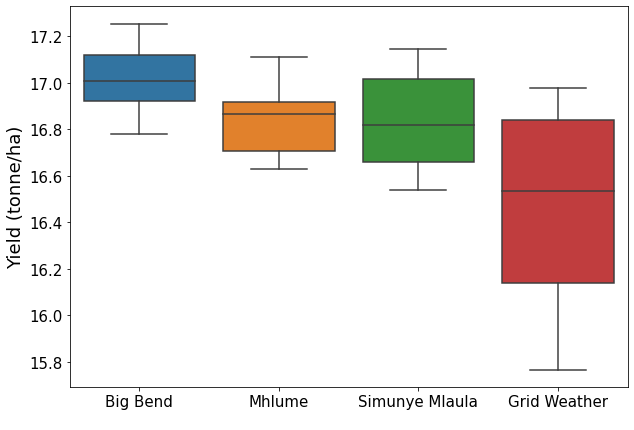

In [816]:
#create figure
fig,ax=plt.subplots(1,1,figsize=(10,7),)

# create box plot
sns.boxplot(data=all_outputs,x='label',y='Yield (tonne/ha)',ax=ax,)

# labels and font sizes
ax.tick_params(labelsize=15)
ax.set_xlabel(' ')
ax.set_ylabel('Yield (tonne/ha)',fontsize=18)

In [804]:
model_sm._outputs.final_stats.to_excel('MS.xlsx')

In [ ]:
## Initial Water
InitWC = InitialWaterContent(value=['FC'])

##Irrigation
net_irrigation = IrrigationManagement(irrigation_method=4,NetIrrSMT=70)

##Crop
sugercane = Crop('SugarCane', planting_date='11/1', harvest_date='04/10',CGC=0.420,
                 CDC=0.226,
                 PlantPop=100000)
##Management


##Groundwater




# combine into aquacrop model and specify start and end simulation date
model_a = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_data,
                      soil=clay_loam,
                      crop=sugercane,
                     initial_water_content=InitWC)
model_a.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_bb = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_bb,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        groundwater=GroundWater(water_table='Y',
                                       dates=[f'{2000}/10/01'],
                                       values=[1]),
                        irrigation_management=net_irrigation)
model_bb.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_mh = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_mh,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        irrigation_management=net_irrigation)
model_mh.run_model(till_termination=True)

# combine into aquacrop model and specify start and end simulation date
model_sm = AquaCropModel(sim_start_time=f'{2000}/01/31',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_sm,
                      soil=clay_loam,
                      crop=sugercane,
                      initial_water_content=InitWC,
                        irrigation_management=net_irrigation)
model_sm.run_model(till_termination=True)

# Custom soils

In [74]:
custom = Soil('custom',cn=46,rew=7)

In [75]:
custom.add_layer(thickness=custom.zSoil,thWP=0.24,
                 thFC=0.40,thS=0.50,Ksat=155,
                 penetrability=100)

In [76]:
custom = Soil('custom',cn=46,rew=7)
custom.add_layer_from_texture(thickness=custom.zSoil,
                              Sand=10,Clay=35,
                              OrgMat=2.5,penetrability=100)

In [77]:
custom.profile

,Comp,Layer,dz,dzsum,zBot,z_top,zMid,th_dry,th_wp,th_fc,th_s,Ksat,penetrability,tau
0,0,1.0,0.1,0.1,0.1,0.0,0.05,0.1075,0.215,0.382,0.511,136.4,100,0.48
1,1,1.0,0.1,0.2,0.2,0.1,0.15,0.1075,0.215,0.382,0.511,136.4,100,0.48
2,2,1.0,0.1,0.3,0.3,0.2,0.25,0.1075,0.215,0.382,0.511,136.4,100,0.48
3,3,1.0,0.1,0.4,0.4,0.3,0.35,0.1075,0.215,0.382,0.511,136.4,100,0.48
4,4,1.0,0.1,0.5,0.5,0.4,0.45,0.1075,0.215,0.382,0.511,136.4,100,0.48
5,5,1.0,0.1,0.6,0.6,0.5,0.55,0.1075,0.215,0.382,0.511,136.4,100,0.48
6,6,1.0,0.1,0.7,0.7,0.6,0.65,0.1075,0.215,0.382,0.511,136.4,100,0.48
7,7,1.0,0.1,0.8,0.8,0.7,0.75,0.1075,0.215,0.382,0.511,136.4,100,0.48
8,8,1.0,0.1,0.9,0.9,0.8,0.85,0.1075,0.215,0.382,0.511,136.4,100,0.48
9,9,1.0,0.1,1.0,1.0,0.9,0.95,0.1075,0.215,0.382,0.511,136.4,100,0.48


In [78]:
custom = Soil('custom',cn=46,rew=7)

custom.add_layer(thickness=0.3,thWP=0.24,
                 thFC=0.40,thS=0.50,Ksat=155,
                 penetrability=100)

custom.add_layer_from_texture(thickness=1.5,
                              Sand=10,Clay=35,
                              OrgMat=2.5,penetrability=100)

custom.profile

,Comp,Layer,dz,dzsum,zBot,z_top,zMid,th_dry,th_wp,th_fc,th_s,Ksat,penetrability,tau
0,0,1.0,0.1,0.1,0.1,0.0,0.05,0.1200,0.240,0.400,0.500,155.0,100.0,0.51
1,1,1.0,0.1,0.2,0.2,0.1,0.15,0.1200,0.240,0.400,0.500,155.0,100.0,0.51
2,2,1.0,0.1,0.3,0.3,0.2,0.25,0.1200,0.240,0.400,0.500,155.0,100.0,0.51
3,3,2.0,0.1,0.4,0.4,0.3,0.35,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
4,4,2.0,0.1,0.5,0.5,0.4,0.45,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
5,5,2.0,0.1,0.6,0.6,0.5,0.55,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
6,6,2.0,0.1,0.7,0.7,0.6,0.65,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
7,7,2.0,0.1,0.8,0.8,0.7,0.75,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
8,8,2.0,0.1,0.9,0.9,0.8,0.85,0.1075,0.215,0.382,0.511,136.4,100.0,0.48
9,9,2.0,0.1,1.0,1.0,0.9,0.95,0.1075,0.215,0.382,0.511,136.4,100.0,0.48


# Groundwater

In [81]:
# constant groundwater depth of 2m
gw_model = AquaCropModel(sim_start_time=f'{1995}/10/01',
                      sim_end_time=f'{2014}/01/01',
                      weather_df=weather_data,
                      soil=sandy_loam,
                      crop=wheat,
                      initial_water_content=InitWC,            
                      groundwater=GroundWater(water_table='Y',
                                       dates=[f'{1995}/10/01'],
                                       values=[2])
                    )

In [82]:
gw_model.run_model(till_termination=True)

True

In [83]:
gw_model._outputs.final_stats

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Maize,1996-02-10,131,13.848702,0
1,1,Maize,1997-02-10,497,14.265383,0
2,2,Maize,1998-02-10,862,14.290760,0
3,3,Maize,1999-02-10,1227,14.179298,0
4,4,Maize,2000-02-10,1592,14.421791,0
5,5,Maize,2001-02-10,1958,14.339423,0
6,6,Maize,2002-02-10,2323,14.306611,0
7,7,Maize,2003-02-10,2688,14.473195,0
8,8,Maize,2004-02-10,3053,14.317730,0
9,9,Maize,2005-02-10,3419,14.510294,0


In [84]:
# model._outputs.water_flux.head()
# model._outputs.water_storage.head()
# model._outputs.crop_growth.head()
model._outputs.final_stats.head()

,Season,crop Type,Harvest Date (YYYY/MM/DD),Harvest Date (Step),Yield (tonne/ha),Seasonal irrigation (mm)
0,0,Maize,1996-02-10,131,13.688820,0
1,1,Maize,1997-02-10,497,14.279829,0
2,2,Maize,1998-02-10,862,14.284479,0
3,3,Maize,1999-02-10,1227,13.711132,0
4,4,Maize,2000-02-10,1592,14.434245,0
